Beyond scRNAseq: neuronal recordings
====================================

In this tutorial we are showing the applicability of scFates on other high-dimensional datasets, such as single neuronal acitvity recordings, in order to extract population dynamics.

## The dataset and preprocessing

In this example we will use data from [Peyrache et al](https://www.nature.com/articles/nn.3968), which is a study on mammalian head direction cell recordings. Here is the figure 1 that summaries the location and data recorded:

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnn.3968/MediaObjects/41593_2015_Article_BFnn3968_Fig1_HTML.jpg)

The data used for this tutoral includes recordings from 22 neurons located in the anterodorsal thalamic nucleus (ADn) of a single mouse that was awake and foraging in an open environment, with measured head angles.

### Preprocessing

Following [Chaudhuri et al.](http://10.1038/s41593-019-0460-x) method, spike times were converted into time-varying rates. Firing rates were estimated by convolving the spike times with a Gaussian kernel of standard deviation 100 ms. The rates were then replaced by their square root to stabilize the variance. For each timepoint is the related measured angle.

## Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import palantir
import anndata
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import scFates as scf
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.colors as col
sc.set_figure_params()
%matplotlib inline

N = 256
flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))

angle_u = 'https://github.com/LouisFaure/scFates_notebooks/raw/main/data/angles.csv.gz'
counts_u = 'https://github.com/LouisFaure/scFates_notebooks/raw/main/data/counts.csv.gz'

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [2]:
counts=pd.read_csv(counts_u,header=None)
counts.index=counts.index.astype(str)
counts.columns=counts.columns.astype(str)
counts.shape

(22841, 22)

In [3]:
adata=anndata.AnnData(counts)
adata.obs['angles']=np.degrees(pd.read_csv(angle_u, header=None).values)

In [4]:
adata.obs['time']=np.arange(0,adata.shape[0]*0.05,0.05)

## Dimensionality reduction

### PCA

In [5]:
sc.pp.pca(adata)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


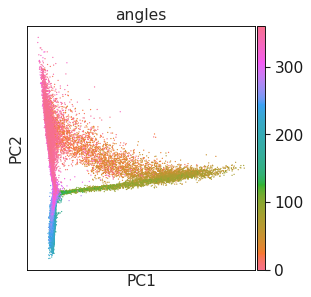

In [6]:
sc.pl.pca(adata,color="angles",cmap=flat_huslmap)

### Multi-scale diffusion maps

In [7]:
sce.tl.palantir(adata)
adata

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 22841 × 22
    obs: 'angles', 'time'
    uns: 'pca', 'palantir_EigenValues'
    obsm: 'X_pca', 'X_palantir_diff_comp', 'X_palantir_multiscale'
    varm: 'PCs'
    layers: 'palantir_imp'
    obsp: 'palantir_diff_op'

In [8]:
adata.obsm["X_palantir_multiscale"].shape

(22841, 7)

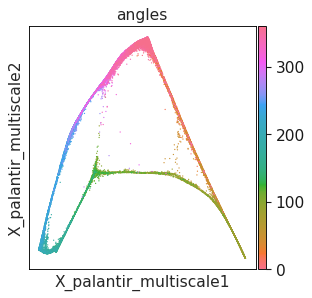

In [9]:
sc.pl.embedding(adata,basis='X_palantir_multiscale',color='angles',cmap=flat_huslmap)

### Show several dimensions of multiscale diffusion space

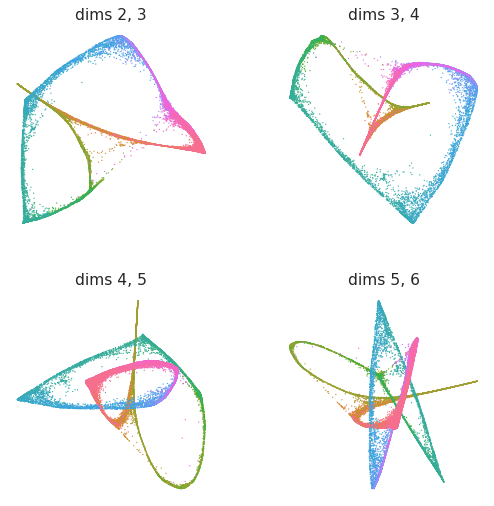

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
for d in np.arange(2,6):
    sc.pl.embedding(adata,basis='X_palantir_multiscale',
                    title="dims %d, %d"%(d,d+1),
                    components=(int(d),int(d+1)),
                    color='angles',cmap=flat_huslmap,
                    show=False,ax=axs[d-2],frameon=False)
    
    # complex way to remove the side colorbar
    axs[d-2].set_box_aspect(aspect=1)
    fig = axs[d-2].get_gridspec().figure
    cbar = np.argwhere(
        ["colorbar" in a.get_label() for a in fig.get_axes()]
    ).ravel()
    if len(cbar) > 0:
        fig.get_axes()[cbar[0]].remove()

## Principal circle fitting

In [11]:
scf.tl.circle(adata,Nodes=100,use_rep="X_palantir_multiscale",device="gpu")

inferring a principal circle --> parameters used 
    100 principal points, mu = 0.1, lambda = 0.01
    removed 7 non assigned nodes
    finished (0:01:23) --> added 
    .uns['epg'] dictionnary containing inferred elastic circle generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


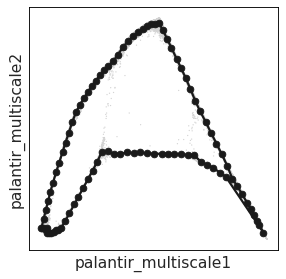

In [12]:
scf.pl.graph(adata,basis='palantir_multiscale')

### Select root node with cells active at minimum angle

In [13]:
scf.tl.root(adata,"angles",min_val=True)

automatic root selection using angles values
node 31 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
--> updated
    .uns['graph']['B'] with circle now converted to curved trajectory.
    .uns['graph']['tips'] new tips delimitating the trajectory.


In [14]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


## Visualising data

### Comparing pseudotime and measured angles

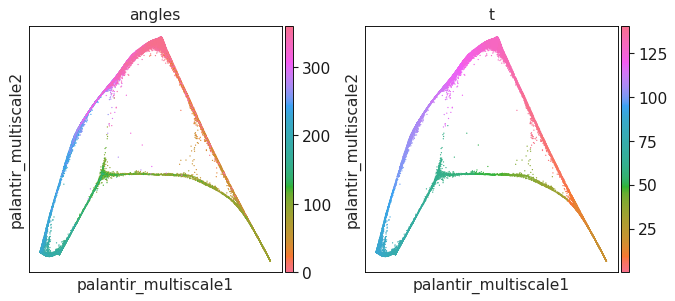

In [15]:
sc.pl.embedding(adata,basis='palantir_multiscale',
                color=['angles','t'],cmap=flat_huslmap)

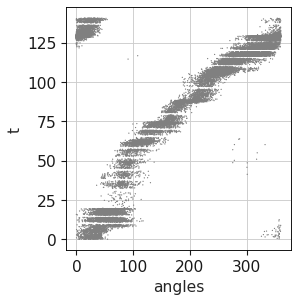

In [16]:
sc.pl.scatter(adata,x='angles',y='t')

### GAM fit of single neuron activities

In [17]:
scf.tl.fit(adata,features=adata.var_names,n_jobs=22)

fit features associated with the trajectory
    single mapping : 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:20) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


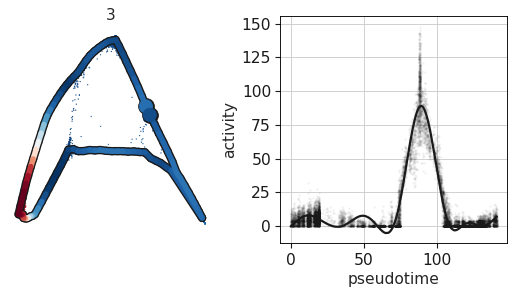

In [18]:
scf.pl.single_trend(adata,'3',basis='palantir_multiscale',frameon=False,
                    color_exp="k",alpha_expr=.04,ylab='activity')

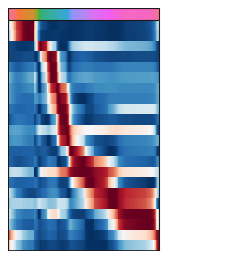

In [19]:
g=scf.pl.trends(adata,plot_emb=False,highlight_features=[],ordering="max",
              fig_heigth=6,pseudo_cmap=flat_huslmap,ord_thre=.95,return_genes=True)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


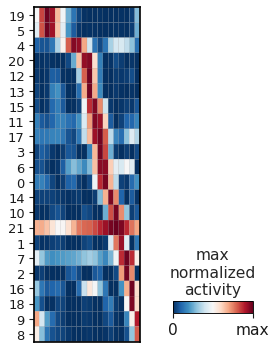

In [20]:
scf.pl.matrix(adata,features=g,nbins=20,
              cmap="RdBu_r",annot_top=False,
              colorbar_title="max\nnormalized\nactivity")